In [2]:
import numpy as np 
from scipy.spatial.distance import cdist   
from matplotlib import pyplot as plt 

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Part 1 and 2 are basic data science skills questions, the main project is in the last parts, Part 3 and 4. 

# Part 1 

Change the code below, ie the [variances and covariances](https://numpy.org/doc/stable/reference/random/generated/numpy.random.Generator.multivariate_normal.html), to make the data distribution of x closer to this image:

<img src="upperleft.png" height=500 width=500>

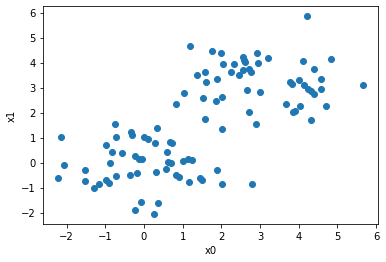

In [110]:
# Part 1:

# number of samples per cluster
pts = 50 

# random number generator
rng = np.random.default_rng()

a = rng.multivariate_normal(
    mean=[3,3], 
    cov=[[1,0],
         [0,1]], 
    size=pts,
)

b = rng.multivariate_normal(
    mean=[0,0], 
    cov=[[1,0],
         [0,1]], 
    size=pts,
)

x = np.concatenate((a, b))

# Plot data 
plt.scatter(x[:, 0], x[:, 1])
plt.xlabel("x0")
plt.ylabel("x1")
plt.show()

# Part 2

Fix the bug in this k-mean clustering function, use it to cluster the combined data `x` (not `a` and `b`) then plot the resulting color labeled clusters like this:

<img src="Q2.png" height=500 width=500>

Add Comments `#like this ` to show where the changes you made are, and to explain how the function now works correctly

In [ ]:
# Part 2:

def kmeans(x, k, no_of_iterations):  
    
    """ Function to implement k-means clustering 
    # x is a (num_samples, 2) numpy array 
    # k is number of clusters 
    # no_of_iterations is the number of iterations to run k means
    """
    
    # Randomly choose initial Centroids 
    idx = np.random.choice(len(x), k, replace=False)         
    
    centroids = x[idx, :]       
    distances = cdist(x, centroids ,'euclidean')          
    points = np.array([np.argmax(i) for i in distances])  
    
    # main loop
    for _ in range(no_of_iterations):  
        
        centroids = []      
        
        for idx in range(k):     
            
            temp_cent = x[points==idx].mean(axis=1)   
            centroids.append(temp_cent) 
            centroids = np.vstack(centroids)  
            distances = cdist(x, centroids ,'euclidean')    
            
        points = np.array([np.argmax(i) for i in distances])              
            
    return points

# use function
points = kmeans(x,k=2,no_of_iterations=10)

# assign clusters
cluster1 = x[points==0]
cluster2 = x[points==1]

# Plot the data in labeled clusters 
plt.scatter(cluster1[:, 0], cluster1[:, 1])
plt.scatter(cluster2[:, 0], cluster2[:, 1])
plt.xlabel("x0")
plt.ylabel("x1")
plt.show()

# Part 3

## Intro to Part 3

We will be retraining the autoregressive large language model GPT2 from this paper [Language Models are Unsupervised Multitask Learners](https://cdn.openai.com/better-language-models/language_models_are_unsupervised_multitask_learners.pdf) to perform some new tasks for us. 

We have provided some starter code below and in `utils.py` that shows how we can load a pretrained large language model.

In `utils.py` you will find a rudimentary class called `BaseAgent` with a class method called `memorize` that can be used to retrain (aka finetune) the model. This is not the best way to finetune, but it can be used as starter code to a new method that can finetune the model. 

In the cells below, I demonstrate how this class is used to overlearn, aka memorize, one conversational example, aka one sample.

In [22]:
#sys libs
import os
import sys
import random
import time

#data manupulation libs
import numpy as np

#string manupulation libs
import re
import string

#torch libs
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim

print('torch.cuda.device_count()', torch.cuda.device_count())
print('torch.cuda.empty_cache()', torch.cuda.empty_cache())

#huggingface transformers
import transformers
from transformers import set_seed
from transformers import GPT2Tokenizer, GPT2LMHeadModel

print(transformers.__version__)

# Custom Code
from utils import BaseAgent

# seeds
set_seed(42)
np.random.seed(0)
random.seed(0)
torch.manual_seed(0)

%load_ext autoreload
%autoreload 2
%matplotlib inline

torch.cuda.device_count() 2
torch.cuda.empty_cache() None
4.15.0
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [100]:
# download the gpt transformer model and tokenizer

pretrained_hf_model = 'gpt2'

cache_dir = os.path.join(
    "./modelstates/hugface_models/",
    pretrained_hf_model,
)

print("cache_dir=", cache_dir)

model_save_path = os.path.join(
    "./modelstates/finetuned_models",
    pretrained_hf_model,
)

print("model_save_path=", model_save_path)

tokenizer = GPT2Tokenizer.from_pretrained(
    pretrained_hf_model,
    pad_token='<|endoftext|>',
)

model = GPT2LMHeadModel.from_pretrained(
    pretrained_hf_model,
    cache_dir=cache_dir,
)

# place the model and tokenizer into our dialog agent

agent = BaseAgent(
    tokenizer = tokenizer,
    model = model,
)

cache_dir= ./modelstates/hugface_models/gpt2
model_save_path= ./modelstates/finetuned_models/gpt2


In [102]:
# an example of how the pretrained model can extend dialog

generated_text = agent.get_response(
    prompt = "A: Hello.\nB: Hi.\nA: How was your day?\nB:",
    max_len = 64
)

print(generated_text)

generated_text

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


A: Hello.
B: Hi.
A: How was your day?
B: I was in the hospital.
A: What was your name?
B: I was in the hospital.
A: What was your name?
B: I was in the hospital.
A: What was your name?
B: I was in the hospital.
A: What was your name


'A: Hello.\nB: Hi.\nA: How was your day?\nB: I was in the hospital.\nA: What was your name?\nB: I was in the hospital.\nA: What was your name?\nB: I was in the hospital.\nA: What was your name?\nB: I was in the hospital.\nA: What was your name'

#### Hint:

Suppose you want to learn the sequence

**all dogs are good boys**

and suppose you are using word tokenization instead of subword or byte pair encoding

Then the target sequence, aka labels, aka `y`, aka target output would be the source sequence, aka input sequence, aka `x`, just shifted to the right by one position

source: **all dogs are good**

target: **dogs are good boys**

this is why in `memorize` you see thise lines doing the same as above

```python
        source_ids = prompt_ids[:,:-1]
        target_ids = prompt_ids[:,1:]
        source_mask = prompt_mask[:,:-1]
        target_mask = prompt_mask[:,1:]
```

In [103]:
# an example of how to learn to extend in a directed manner

agent.memorize(
    "A: Hello.\nB: Hi.\nA: How was your day?\nB: First, you tell me about your day.",
    num_epochs = 5,
)

epoch 0 loss 2.4595978260040283
epoch 1 loss 2.0394985675811768
epoch 2 loss 1.7277195453643799
epoch 3 loss 1.043565273284912
epoch 4 loss 0.9133180379867554


In [104]:
# how did our retraining change the model?

generated_text = agent.get_response(
    prompt = "A: Hello.\nB: Hi.\nA: How was your day?\nB:",
    max_len = 64
)

print(generated_text)

generated_text

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


A: Hello.
B: Hi.
A: How was your day?
B: First, you tell me about your day.
B: First, you tell me about your day.
A: First, you tell me about your day.
B: First, you tell me about your day.
A: First, you tell me about your day.
B: First, you tell


'A: Hello.\nB: Hi.\nA: How was your day?\nB: First, you tell me about your day.\nB: First, you tell me about your day.\nA: First, you tell me about your day.\nB: First, you tell me about your day.\nA: First, you tell me about your day.\nB: First, you tell'

## Data for Part 3

Next lets introduce you to the dataset you will be using for this project. This is a text dataset with multiple conversations, or dialogs, where one of the individuals is acting very empathetically towards the other, and each dialog is labeled by the emotion in that dialog, ie one of 32 different emotions: 

```python
emotion_list = ['sentimental', 'afraid', 'proud', 'faithful', 'terrified', 'joyful', 
                'angry', 'sad', 'jealous', 'grateful', 'prepared', 'embarrassed', 'excited', 
                'annoyed', 'lonely', 'ashamed', 'guilty', 'surprised', 'nostalgic',
                'confident', 'furious', 'disappointed', 'caring', 'trusting', 'disgusted', 
                'anticipating', 'anxious', 'hopeful', 'content', 'impressed', 'apprehensive', 
                'devastated']

len(emotion_list) # 32
```
here are instructions on how to download and unzip that dataset

```console 
wget https://dl.fbaipublicfiles.com/parlai/empatheticdialogues/empatheticdialogues.tar.gz

tar -xvf empatheticdialogues.tar.gz

rm empatheticdialogues.tar.gz
```

The unzipped folder has a training, validation and test set split

```
os.listdir(path_to_empatheticdialogues)

# ['train.csv', 'test.csv', 'valid.csv']
```

you can load the train dataset like this

```python
splitname = "train"
df = open(os.path.join(path_to_empatheticdialogues, f"{splitname}.csv")).readlines()
print(df[0].strip().split(","))

# ['conv_id', 'utterance_idx', 'context', 'prompt', 'speaker_idx', 'utterance', 'selfeval', 'tags']
```

the emotion is under the `context` column, the topic of the conversation is under the `prompt` column, and each speaker's utterance, aka conversational turn, is under the `utterance` column.

```python
for i in range(1, len(df)):
    
    data_line = df[i].strip().split(",")
    
    context = data_line[2]
    prompt = data_line[3].replace("_comma_", ",")
    
print(prompt, " <EMOTION_TYPE> ", context, ' <|endoftext|>')

# I remember going to the fireworks with my best friend. There was a lot of people, but it only felt like us in the world. <EMOTION_TYPE> sentimental <|endoftext|>
```

Hint:

With some edits to the training data, a autoregressive model can be turned into a sentiment analysis classifier. Instead of predicting a set of logits for your different classes, like a sentiment classifier, or predicting the next token, like an autoregressive model, have the model predict the right tokens to explain to you what class of emotion the preceding text is (which of the 32 emotions in this case) as the last tokens of a sequence. Use special tokens like `<EMOTION_TYPE>` and `<|endoftext|>` to signify the difference between text and special outputs. 

## Goals for Part 3

There are 5 goals for this project:

#### 1. Preprocess the data into a training and validation set (no need for a test set for this minimal project). The preprocessed dataset should be preprocessed in such a way that it can be used to retrain the large language model as an autoregressive sentiment classifier. For example, the model will be passed:

`I am going on my second date with this guy that seems so far to really connect with me, I want to believe this is, you know, "the one".`

and the model is expected to complete the sequence:

`I am going on my third date with this person that seems, so far, to really connect with me. I want to believe this is ... you know ... "the one". <EMOTION_TYPE> hopeful <|endoftext|>`

(You do NOT need to use all the data in the data folder for this project, you do not have to use a specific split of the data, just use enough data to accomplish your goals, and set aside the validation set so that it is valid according to the definition of a validation)

Feel free to use the starter code, it is written in PyTorch to give you full control of the training, but has some major features missing. For example:

 a. you would have to edit it to allow different batch sizes. 
 b. it does not keep track of the train and validation losses
 c. there is no early stopping or model saving built in
 
You dont have to use the starter code, feel free to use the [huggingface functionality](https://huggingface.co/course/chapter7/6?fw=pt)

Please make your preprocessing code clean, simple and easy to read and explain. Preferably with examples. 

#### 2. Answer this question: what is the majority classifier, aka [ZeroR (or Zero Rate)](https://towardsdatascience.com/calculating-a-baseline-accuracy-for-a-classification-model-a4b342ceb88f), accuracy on the validation set that you set aside?

explain how you calculated your answer

#### 3. Rewrite the `BaseAgents`'s `memorize` method found in `utils.py` to accomplish the goal of retraining the model as a autoregressive sentiment classifier. 

Add an `evaluator` method that calculates the validation set accuracy, accuracy of predicting the correct emotion. While you are retraining the model, keep track of the validation and training losses for each epoch or each batch, output these 2 arrays of losses for plotting in the next step. Also while you are retraining the model, keep track of the validation and training accuracies for each epoch or each batch, output these 2 arrays of accuracies for plotting in the next step.

plot a learning curve that has this general shape for the losses:


#### 4. Train the model to become a autoregressive sentiment classifier. Show us the training curve, aka learning curve, plots by displaying it in this notebook.

your plots should have this general shape for the losses

<img src="trainingcurve.png" height=500 width=500>

the accuracy plot should look like the losses plot above, only flipped upside down. 

#### 5. Show us 4 examples of the model working correctly and 4 examples of the model working incorrectly

# Question 4 (Optional)

This part is optional, there is no need to do it if you run out of time doing Question 1 thru 3. 

Do something creative and fun with this project and show us. 

For example: 

1. retrain the model to be a more empathetic chatbot and let us talk to the chatbot

```python
 while True:
    tell_bot = input("Human > ")
    bot_reply = talk_to_bot(tell_bot)
    if ("bye" in tell_bot):
        print('Bot > '+ bot_reply + '\n')
        break
    else:
        print('Bot > '+ bot_reply + '\n') 

```



```console
AI: Hello.
Human: Hi.
AI: How was your day?
Human: I just found out i was rejected from that collage I applied to.
AI: Im sorry to hear that, was it one you were really needed to get into?
Human: no, it just hurts my ego.
AI: i also am sad when rejected. the right one for you though is one that will accept you.
Human: what emotion am i feeling?
AI: disappointed
```

2. deploy the chatbot to an API

# Tips

1. put most of your work in `utils.py` and use this notebook for demonstration purposes
2. for important parts of the code, write the code intuitively (reads easily, self-explanatory), with good documentations a comments, see `cross_entropy_loss` in utils.py
3. extra points if the notebook is clean and easy to follow along with even without you presenting it
4. you dont have to train on all the data or use this large of a model if you dont have the compute resources, although [google colab](https://colab.research.google.com/) has free GPUs and this model and data will fit onto a colab notebook just fine. What you do need to be able to do is to explain how you preprocessed the data for training and how you trained the model to produce the learning curves